In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# %% Imports

from collections import defaultdict

import arff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import resample
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2

from calc_metrics import calc_metrics
from create_data_overview import create_data_overview
from enc_categ_vars import enc_categ_vars
from save_fig import save_fig

In [ ]:
# %% External Files

data_freq = arff.load("data/freMTPL2freq.arff")

df_freq = pd.DataFrame(
    data_freq,
    columns=[
        "IDpol",
        "ClaimNb",
        "Exposure",
        "Area",
        "VehPower",
        "VehAge",
        "DrivAge",
        "BonusMalus",
        "VehBrand",
        "VehGas",
        "Density",
        "Region",
    ],
)

data_sev = arff.load("data/freMTPL2sev.arff")
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

In [ ]:
# %% Cockpit

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

plt.close("all")
sns.set_theme(style="whitegrid")

In [ ]:
# %% Create data overview for df_freq

create_data_overview(df=df_freq)

Shape of the DataFrame: (678013, 12)

Variable Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 678013 entries, 0 to 678012
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   IDpol       678013 non-null  float64
 1   ClaimNb     678013 non-null  float64
 2   Exposure    678013 non-null  float64
 3   Area        678013 non-null  object 
 4   VehPower    678013 non-null  float64
 5   VehAge      678013 non-null  float64
 6   DrivAge     678013 non-null  float64
 7   BonusMalus  678013 non-null  float64
 8   VehBrand    678013 non-null  object 
 9   VehGas      678013 non-null  object 
 10  Density     678013 non-null  float64
 11  Region      678013 non-null  object 
dtypes: float64(8), object(4)
memory usage: 62.1+ MB
None

Summary of Numerical Variables:
              IDpol        ClaimNb       Exposure       VehPower  \
count  6.780130e+05  678013.000000  678013.000000  678013.000000   
mean   2.62185

In [ ]:
# %% Create data overview for df_sev

create_data_overview(df=df_sev)

Shape of the DataFrame: (26639, 2)

Variable Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26639 entries, 0 to 26638
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   IDpol        26639 non-null  float64
 1   ClaimAmount  26639 non-null  float64
dtypes: float64(2)
memory usage: 416.4 KB
None

Summary of Numerical Variables:
              IDpol   ClaimAmount
count  2.663900e+04  2.663900e+04
mean   2.279864e+06  2.278536e+03
std    1.577202e+06  2.929748e+04
min    1.390000e+02  1.000000e+00
25%    1.087642e+06  6.868100e+02
50%    2.137413e+06  1.172000e+03
75%    3.180162e+06  1.228080e+03
max    6.113971e+06  4.075401e+06

First Few Rows:
       IDpol  ClaimAmount
0     1552.0       995.20
1  1010996.0      1128.12
2  4024277.0      1851.11
3  4007252.0      1204.00
4  4046424.0      1204.00


In [ ]:
# %% Shaping

# Aggregate claim amount if there are multiple damages for the same ID
df_sev = df_sev.groupby("IDpol")["ClaimAmount"].sum()

# Merge
df = pd.merge(left=df_freq, right=df_sev, how="left", on="IDpol")

# Missing claim amounts correspont to 0
df.loc[df["ClaimAmount"].isna(), "ClaimAmount"] = 0

df["ClaimNb"].value_counts()

# Create dummy variable for claim
df["HadClaim"] = 0
df.loc[df["ClaimAmount"] > 0, "HadClaim"] = 1

# Drop ID
df = df.drop("IDpol", axis=1)

In [ ]:
# %% Descriptives for the numerical variables

df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,HadClaim
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,678013.000000
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,0.036790
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,0.188246
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.000000


In [ ]:
# %% Descriptives for the categorical variables

df.describe(include="object")

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12',Regular,'R24'
freq,191880,166024,345877,160601


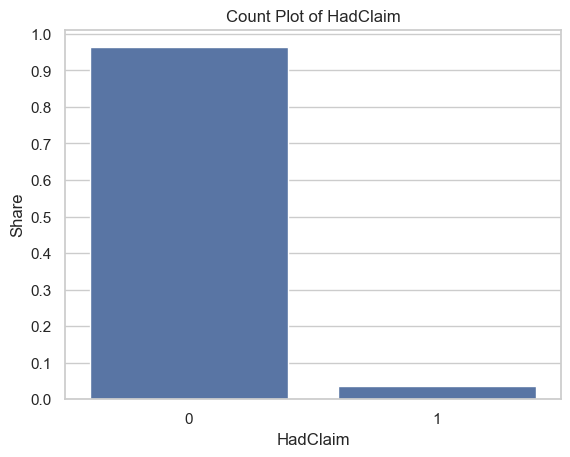

In [ ]:
# %% Distribution of HadClaim

_, ax = plt.subplots()
sns.countplot(
    data=df,
    x="HadClaim",
    order=df["HadClaim"].value_counts().index,
    ax=ax,
    stat="probability",
)
ax.set(title="Count Plot of HadClaim", xlabel="HadClaim", ylabel="Share")
plt.yticks(np.arange(0, 1.01, 0.1))
save_fig("countplot_hadclaim")
plt.show(block=False)

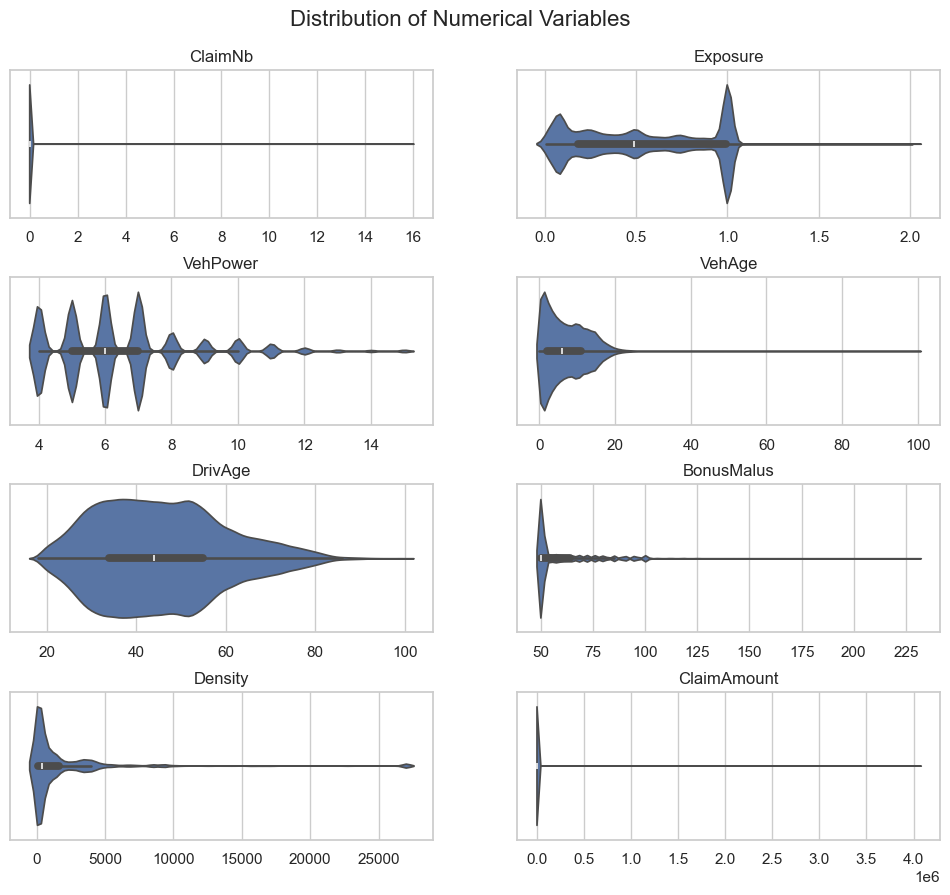

In [ ]:
# %% Distribution of numerical variables

num_vars = df.select_dtypes(include=[float]).columns

fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax = ax.flatten()
for i, col in enumerate(num_vars):
    sns.violinplot(data=df, x=col, ax=ax[i])
    ax[i].set(title=col, xlabel="", ylabel="")
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle("Distribution of Numerical Variables", fontsize=16, y=0.94)
save_fig("dist_num_vars")
plt.show(block=False)

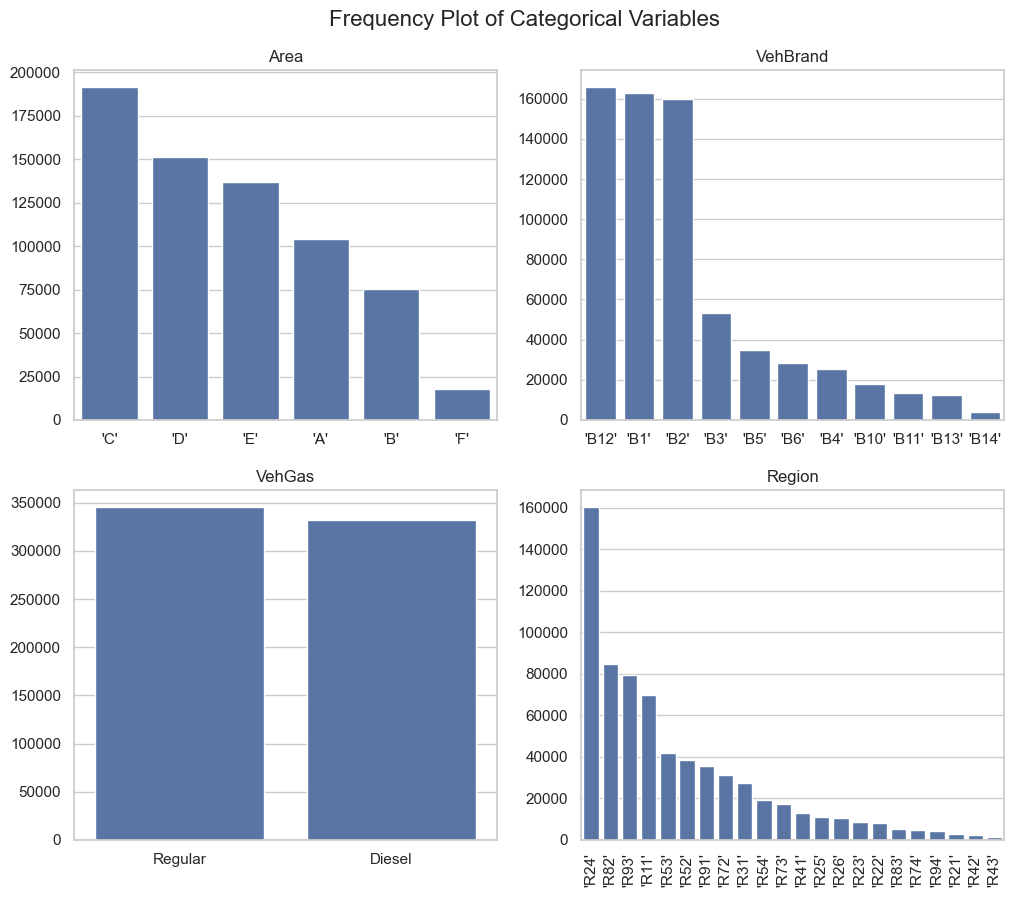

In [ ]:
# %% Distribution of categorical variables

categ_vars = df.select_dtypes(include=["object"]).columns

fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax = ax.flatten()
for i, col in enumerate(categ_vars):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=ax[i])
    ax[i].set(title=col, xlabel="", ylabel="")
    if i == 3:
        ax[i].tick_params(axis="x", rotation=90)
fig.suptitle("Frequency Plot of Categorical Variables", fontsize=16, y=0.94)
save_fig("freq_plot_categ_vars")
plt.show(block=False)

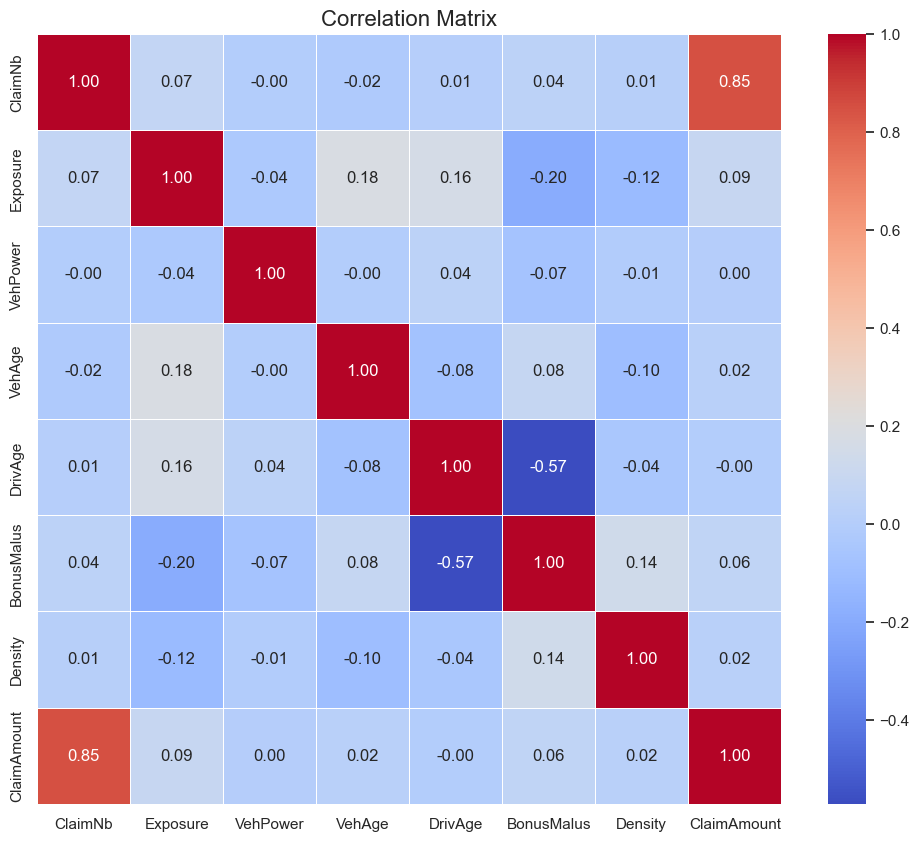

In [ ]:
# %% Correlation Analysis

# Correlations between numerical variables - use Spearman rather than Pearson!
correlation_matrix = df[num_vars].corr(method="spearman")

_, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    ax=ax,
)
plt.title("Correlation Matrix", fontsize=16)
save_fig("heatmap_num_vars")
plt.show(block=False)

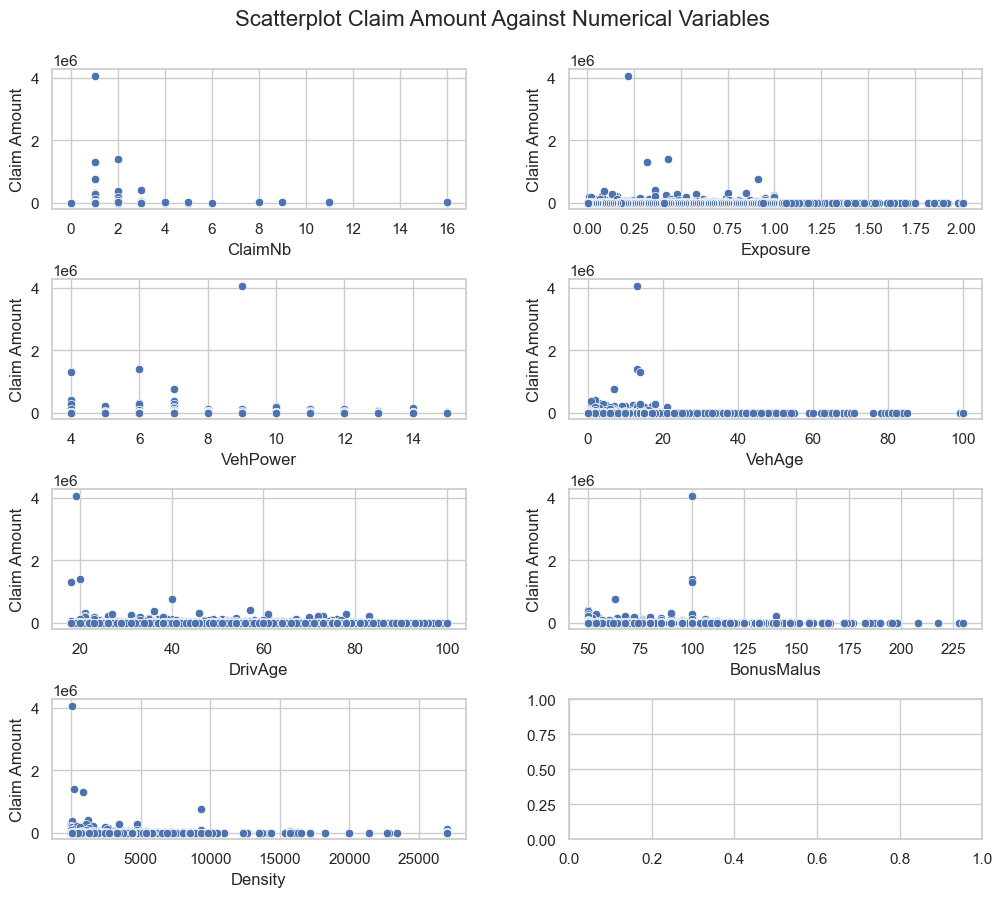

In [ ]:
# %% Eyeballing Potential Relationships Between Target and Features

fig, ax = plt.subplots(4, 2, figsize=(12, 10))
ax = ax.flatten()
for i, col in enumerate(num_vars):
    if col != "ClaimAmount":
        sns.scatterplot(
            data=df,
            x=col,
            y="ClaimAmount",
            ax=ax[i],
        )
        ax[i].set(title="", xlabel=col, ylabel="Claim Amount")
fig.subplots_adjust(hspace=0.5, wspace=0.25)
fig.suptitle(
    "Scatterplot Claim Amount Against Numerical Variables", fontsize=16, y=0.94
)
plt.show(block=False)

In [ ]:
# %% Encoding

# Onehot encode categorical variables
for col in categ_vars:
    if col != "Region":
        df = enc_categ_vars(df=df, col=col, rm_first=False)

# Label encode Region for computational efficiency (>20 categories)
encoder = LabelEncoder()
df["Region"] = encoder.fit_transform(df["Region"])

In [ ]:
# %% Transformations

X = df.drop(["HadClaim", "ClaimAmount"], axis=1)
y = df["ClaimAmount"].copy()

# Log-transform the target to handle skewness
y = np.log1p(y)  # (add a small constant to avoid log(0))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)

In [ ]:
# %% Standardize the non-dummy features: fit scaler to train and apply on test

scale_vars = X_train.columns[X_train.dtypes != "uint8"]
scaler = StandardScaler()
X_train[scale_vars] = scaler.fit_transform(X_train[scale_vars])
X_test[scale_vars] = scaler.transform(X_test[scale_vars])

In [ ]:
# %% Create a container for storing metrics later

metrics = defaultdict(lambda: defaultdict())

In [ ]:
# %% Zero Inflated Model (Tweedie Family):

# Initialize Tweedie Regressor
tw = TweedieRegressor()

# Define the parameter grid
tw_param_dist = {
    "power": [0, 1, 1.5],
    "alpha": [0.1, 1, 2],
    "fit_intercept": [True, False],
    "link": ["auto", "identity", "log"],
}

# Initialize RandomizedSearchCV
tw_random_search = RandomizedSearchCV(
    estimator=tw,
    param_distributions=tw_param_dist,
    n_iter=10,  # Number of random combinations to try
    scoring="neg_mean_squared_error",  # Metric to evaluate
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Print updates
    random_state=SEED,  # Ensure reproducibility
    n_jobs=-1,  # Use all available CPU cores
)

# Fit the RandomizedSearchCV
tw_random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", tw_random_search.best_params_)
print("Best CV Score (MSE):", tw_random_search.best_score_)

# Use the best model for predictions
best_tw = tw_random_search.best_estimator_
y_pred = best_tw.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'power': 0, 'link': 'identity', 'fit_intercept': True, 'alpha': 0.1}
Best CV Score (MSE): -0.5884910006105705


In [ ]:
# %% Calculate Performance Metrics

metrics["RMSE"]["Tweedie"] = calc_metrics(y_test, y_pred, "rmse")
metrics["R-Squared"]["Tweedie"] = calc_metrics(y_test, y_pred, "r2")
print(f"RMSE Tweedie: {metrics["RMSE"]["Tweedie"]:.4f}")
print(f"R-Squared Tweedie: {metrics["R-Squared"]["Tweedie"]:.4f}")

RMSE Tweedie: 0.7541
R-Squared Tweedie: 0.6796


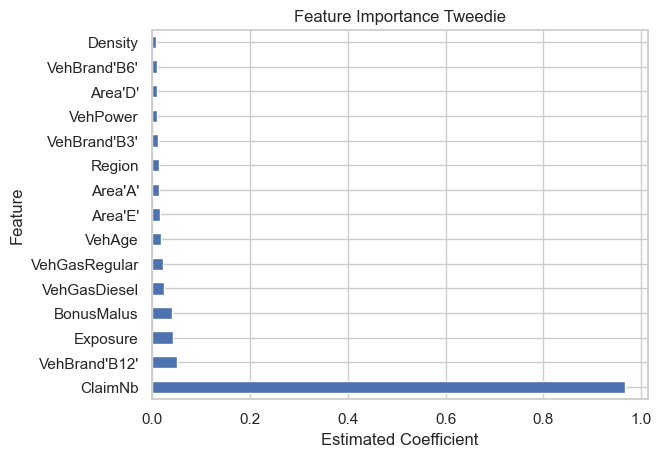

In [ ]:
# %% Feature Importance

feat_import_tw = pd.Series(np.abs(best_tw.coef_), index=X.columns).sort_values(
    ascending=False
)

_, ax = plt.subplots()
feat_import_tw.nlargest(15).plot(kind="barh", ax=ax)
ax.set(
    title="Feature Importance Tweedie",
    xlabel="Estimated Coefficient",
    ylabel="Feature",
)
save_fig("feat_import_tweedie")
plt.show(block=False)

In [ ]:
# %% Neural Network

# Build model
nn = Sequential(
    [
        InputLayer(shape=(X_train.shape[1],)),
        Dense(
            units=128,
            activation="relu",
            kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
        ),
        Dropout(0.3),
        Dense(
            units=64,
            activation="tanh",
            kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
        ),
        Dropout(0.3),
        Dense(
            units=32,
            activation="relu",
            kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
        ),
        Dense(units=1),
    ]
)

nn.compile(
    optimizer="adam",
    loss="mse",  # Mean Squared Error for regression
    metrics=["mse"],
)

# Train the regression model
history = nn.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=1024,
    verbose=1,
)

Epoch 1/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.9919 - mse: 0.8368 - val_loss: 0.7918 - val_mse: 0.4312
Epoch 2/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.7356 - mse: 0.4575 - val_loss: 0.5761 - val_mse: 0.4266
Epoch 3/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5907 - mse: 0.4537 - val_loss: 0.5292 - val_mse: 0.4169
Epoch 4/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5545 - mse: 0.4455 - val_loss: 0.5058 - val_mse: 0.4040
Epoch 5/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5407 - mse: 0.4408 - val_loss: 0.4978 - val_mse: 0.4011
Epoch 6/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5278 - mse: 0.4331 - val_loss: 0.4886 - val_mse: 0.3959
Epoch 7/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5222 - mse: 0.4309 - val_loss: 0.4798 - val_mse: 0.3910
Epoch 8/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.5131 - mse: 0.4251 - val_loss: 0.4754 - val_mse: 0.3879
Epoch 9/20
424/424 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

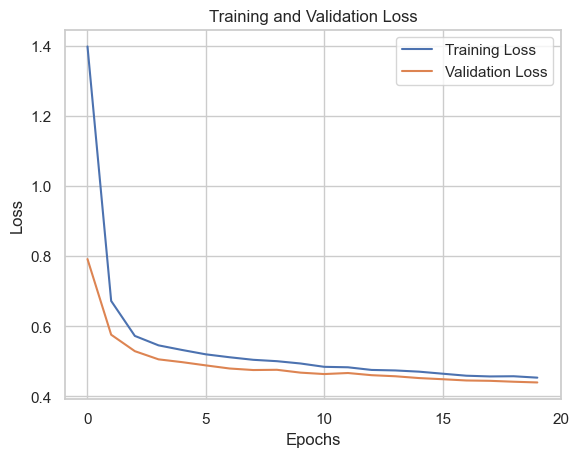

In [ ]:
# %% Plot Training and Validation Loss

_, ax = plt.subplots()
ax.plot(history.history["loss"], label="Training Loss")
ax.plot(history.history["val_loss"], label="Validation Loss")
ax.set(xlabel="Epochs", ylabel="Loss", title="Training and Validation Loss")
plt.xticks(np.arange(0, 25, 5))
plt.legend()
save_fig("nn_train_val_loss")
plt.show(block=False)

In [ ]:
# %% Predict Claim Amounts

y_pred = nn.predict(X_test)

4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 882us/step


In [ ]:
# %% Evaluate Performance

metrics["RMSE"]["NeuralNet"] = calc_metrics(y_test, y_pred, "rmse")
metrics["R-Squared"]["NeuralNet"] = calc_metrics(y_test, y_pred, "r2")
print(f"RMSE Neural Network: {metrics["RMSE"]["NeuralNet"]:.4f}")
print(f"R-Squared Neural Network: {metrics["R-Squared"]["NeuralNet"]:.4f}")

RMSE Neural Network: 0.5972
R-Squared Neural Network: 0.7991


4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 867us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 918us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 873us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 878us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 885us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 984us/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
4238/4238 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step

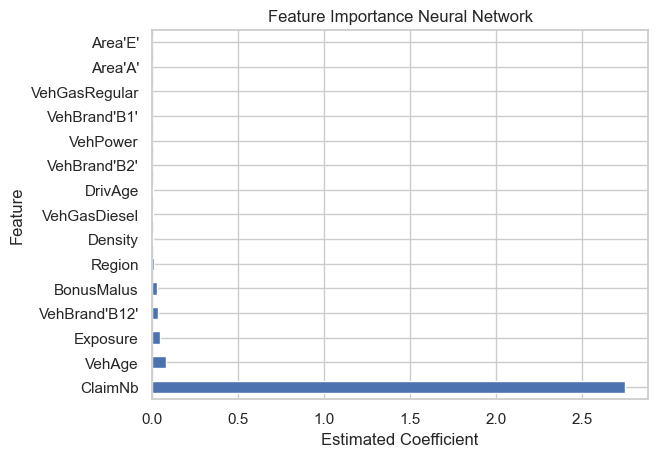

In [ ]:
# %% Feature Importance

feat_import_nn = permutation_importance(
    nn,
    X_test,
    y_test,
    scoring="neg_mean_squared_error",
    n_repeats=2,
    random_state=42,
)

feat_import_nn = pd.Series(
    np.abs(feat_import_nn.importances_mean), index=X.columns
).sort_values(ascending=False)

_, ax = plt.subplots()
feat_import_nn.nlargest(15).plot(kind="barh", ax=ax)
ax.set(
    title="Feature Importance Neural Network",
    xlabel="Estimated Coefficient",
    ylabel="Feature",
)
save_fig("feat_import_neural_net")
plt.show(block=False)

In [ ]:
# %% Random Forest Estimator With Oversampled Non-Zero Claims:

# Oversample non-zero claims to achieve a balanced dataset
X_train_boot, y_train_boot = resample(
    X_train[y_train > 0],
    y_train[y_train > 0],
    n_samples=y_train[y_train == 0].shape[0],
    replace=True,
    random_state=SEED,
)

X_train_boot = pd.concat([X_train_boot, X_train[y_train == 0]], axis=0)
y_train_boot = pd.concat([y_train_boot, y_train[y_train == 0]], axis=0)

In [ ]:
# %% Train Random Forest

rf = RandomForestRegressor(n_estimators=10, random_state=SEED)
rf.fit(X_train_boot, y_train_boot)
y_pred = rf.predict(X_test)

RMSE Random Forest: 0.6021
R-Squared Random Forest: 0.7957


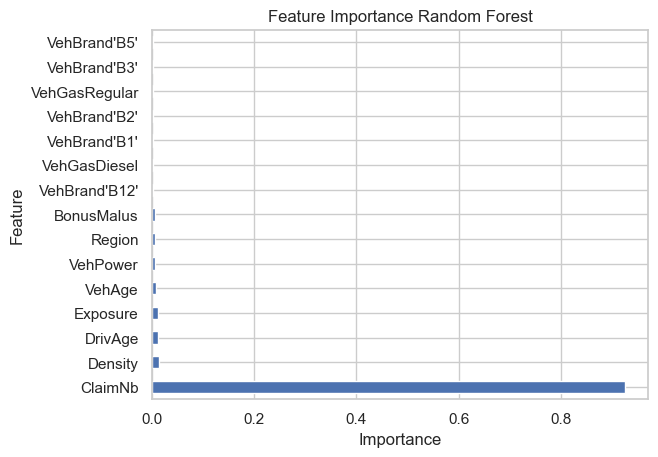

In [ ]:
# %% Evaluate Performance

metrics["RMSE"]["RandomForest"] = calc_metrics(y_test, y_pred, "rmse")
metrics["R-Squared"]["RandomForest"] = calc_metrics(y_test, y_pred, "r2")
print(f"RMSE Random Forest: {metrics["RMSE"]["RandomForest"]:.4f}")
print(f"R-Squared Random Forest: {metrics["R-Squared"]["RandomForest"]:.4f}")

# Feature Importance
feat_import_rf = pd.Series(
    rf.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

_, ax = plt.subplots()
feat_import_rf.nlargest(15).plot(kind="barh", ax=ax)
ax.set(
    title="Feature Importance Random Forest",
    xlabel="Importance",
    ylabel="Feature",
)
save_fig("feat_import_random_forest")
plt.show(block=False)

In [ ]:
# %% Two-Stage Approach With XGBoost

# 1. Classification

# Define class variable
y_train_class = (y_train > 0).astype(int)
y_test_class = (y_test > 0).astype(int)

train_counts = y_train_class.value_counts(normalize=True)
test_counts = y_test_class.value_counts(normalize=True)
df_counts = pd.DataFrame(
    {"Train set": train_counts, "Test set": test_counts}
).sort_index()

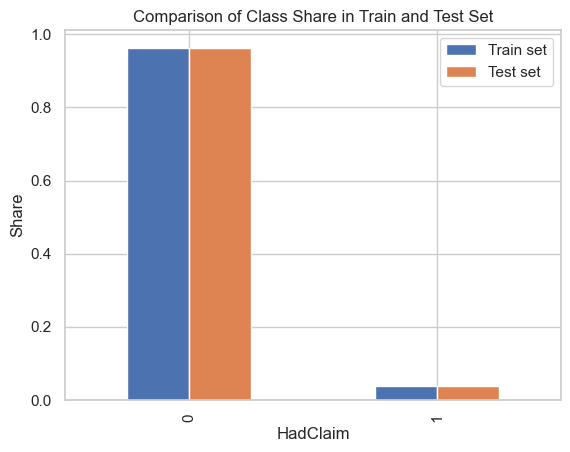

In [ ]:
# %% Demonstrate Equal Share of Positives in Train and Test Set

_, ax = plt.subplots()
df_counts.plot(kind="bar", ax=ax)
ax.set(
    ylabel="Share",
    xlabel="HadClaim",
    title="Comparison of Class Share in Train and Test Set",
)
plt.show(block=False)

In [ ]:
# %% Determine Hyperparameters for XGBoost Classifier

# Hyperparameters grid for RandomizedSearchCV
xgb_param_dist = {
    "n_estimators": [100, 200, 500],
    "max_depth": [2, 5, 8],
    "min_child_weight": [2, 5, 8],
    "subsample": [0.75, 0.9],
    "colsample_bytree": [0.25, 0.5, 0.75],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
}

# Sample weight to tackle imbalanced classes
scaling_weigth = train_counts[0] / train_counts[1]

In [ ]:
# %% Initialize and Train XGBoost Classifier

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    scale_pos_weight=scaling_weigth,
    verbosity=1,
    random_state=SEED,
)

# Set up RandomizedSearchCV
xgb_clf_random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=xgb_param_dist,
    n_iter=10,
    scoring="roc_auc",
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=SEED,
)

xgb_clf_random_search.fit(X_train, y_train_class)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='auc',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rat...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.25, 0.5, 0.75],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 5, 8],
                                        'min_child_weight': [2, 5, 8],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.75, 0.9]},
                   random_state=42, scoring='roc_auc', verbose=2)

In [ ]:
# %% Get the Best Model and Use for Prediction

best_xgb_clf = xgb_clf_random_search.best_estimator_

y_pred_prob = best_xgb_clf.predict_proba(X_test)[:, 1]
y_pred_class = best_xgb_clf.predict(X_test)

In [ ]:
# %% Check Calibration

print(pd.Series(y_pred_class).value_counts(True))

0    0.954699
1    0.045301
Name: proportion, dtype: float64


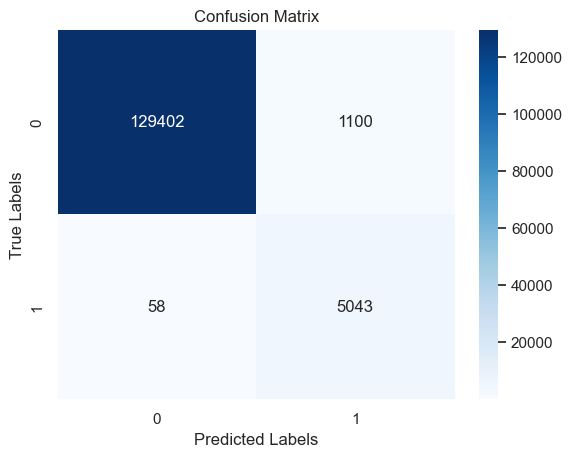

In [ ]:
# %% Plot Confusion Matrix Using Seaborn Heatmap

conf_matrix = confusion_matrix(y_test_class, y_pred_class)
_, ax = plt.subplots()
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="g",
    cmap="Blues",
    xticklabels=[0, 1],
    yticklabels=[0, 1],
    ax=ax,
)
ax.set(
    xlabel="Predicted Labels", ylabel="True Labels", title="Confusion Matrix"
)
save_fig("confusion_matrix")
plt.show(block=False)

In [ ]:
# %% Evaluate Performance

metrics["ROCAUC"]["XGBoostClf"] = calc_metrics(
    y_test_class, y_pred_prob, "rocauc"
)
metrics["F1"]["XGBoostClf"] = calc_metrics(y_test_class, y_pred_class, "f1")
print(f"ROC-AUC XGBoost Classification: {metrics["ROCAUC"]["XGBoostClf"]:.4f}")
print(f"F1-Score XGBoost Classification: {metrics["F1"]["XGBoostClf"]:.4f}")

ROC-AUC XGBoost Classification: 0.9986
F1-Score XGBoost Classification: 0.8970


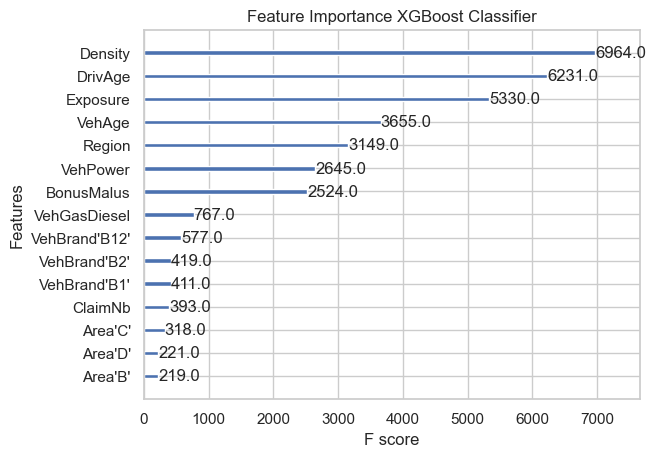

In [ ]:
# %% Plot feature importance

_, ax = plt.subplots()
xgb.plot_importance(best_xgb_clf, max_num_features=15, ax=ax)
ax.set(title="Feature Importance XGBoost Classifier")
save_fig("feat_import_xgboost_clf")
plt.show(block=False)

In [ ]:
# %% 2. Regression

# Only use non-zero claims for train and test set
X_train_reg = X_train[y_train > 0]
y_train_reg = y_train[y_train > 0]
X_test_reg = X_test[y_test > 0]
y_test_reg = y_test[y_test > 0]

In [ ]:
# %% Initialize XGBoost Regressor

xgb_reg = xgb.XGBRegressor(
    objective="reg:squarederror",
    eval_metric="rmse",
    scale_pos_weight=scaling_weigth,
    verbosity=1,
    random_state=SEED,
)

# Set up RandomizedSearchCV
xgb_reg_random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=SEED,
)

xgb_reg_random_search.fit(X_train_reg, y_train_reg)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric='rmse',
                                          feature_types=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rat...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.25, 0.5, 0.75],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [2, 5, 8],
                                        'min_child_weight': [2, 5, 8],
                                        'n_estimators': [100, 200, 500],
                                        'subsample': [0.75, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [ ]:
# %% Get the Best Model for Prediction

best_xgb_reg = xgb_reg_random_search.best_estimator_

y_pred_reg = best_xgb_reg.predict(X_test_reg)

In [ ]:
# %% Evaluate Performance

metrics["RMSE"]["XGBoostReg"] = calc_metrics(y_test_reg, y_pred_reg, "rmse")
metrics["R-Squared"]["XGBoostReg"] = calc_metrics(y_test_reg, y_pred_reg, "r2")
print(f"RMSE XGBoost Regression: {metrics["RMSE"]["XGBoostReg"]:.4f}")
print(
    f"R-Squared XGBoost Regression: {metrics["R-Squared"]["XGBoostReg"]:.4f}"
)

RMSE XGBoost Regression: 1.1047
R-Squared XGBoost Regression: 0.0683


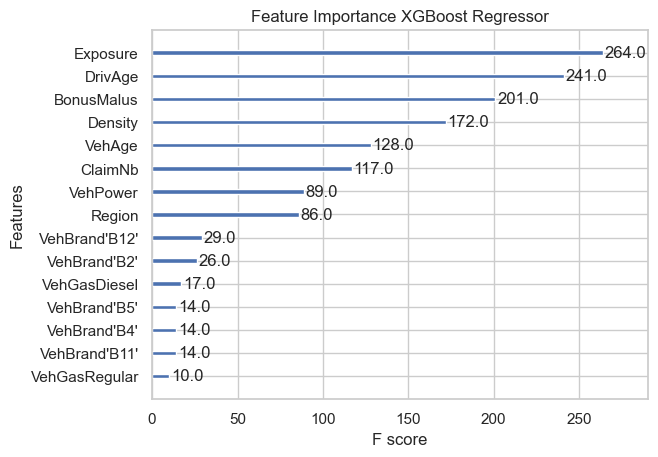

In [ ]:
# %% Plot Feature Importance

_, ax = plt.subplots()
xgb.plot_importance(best_xgb_reg, max_num_features=15, ax=ax)
ax.set(title="Feature Importance XGBoost Regressor")
save_fig("feat_import_xgboost_reg")
plt.show(block=False)

In [ ]:
# %% 3. Final predictions

y_pred = np.zeros_like(y_test, dtype=float)
y_pred[y_pred_class == 1] = best_xgb_reg.predict(X_test[y_pred_class == 1])

In [ ]:
# %% Evaluate Combined Performance

metrics["RMSE"]["XGBoost"] = calc_metrics(y_test, y_pred, "rmse")
metrics["R-Squared"]["XGBoost"] = calc_metrics(y_test, y_pred, "r2")
print(f"RMSE XGBoost: {metrics["RMSE"]["XGBoost"]:.4f}")
print(f"R-Squared XGBoost: {metrics["R-Squared"]["XGBoost"]:.4f}")

RMSE XGBoost: 0.6743
R-Squared XGBoost: 0.7438


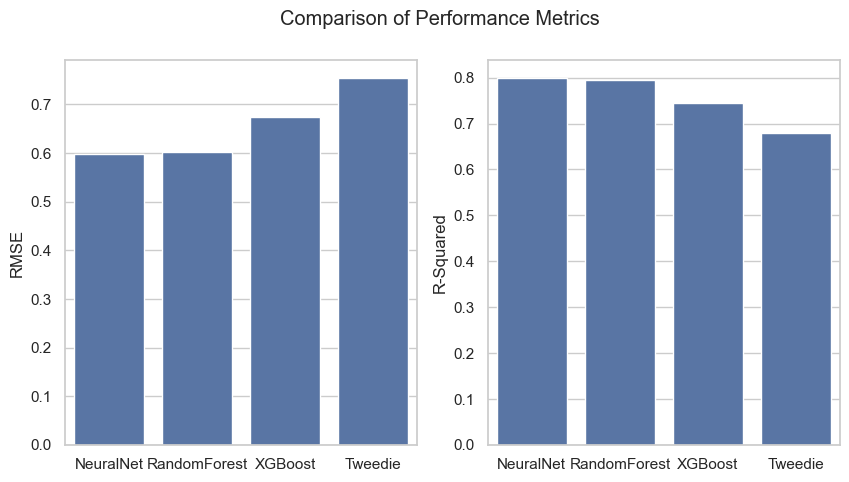

In [ ]:
# %% Comparison of Performance Metrics

metrics_df = pd.DataFrame(
    {"RMSE": metrics["RMSE"], "R-Squared": metrics["R-Squared"]}
)
metrics_df = metrics_df.drop("XGBoostReg")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.barplot(metrics_df["RMSE"].sort_values(), ax=ax[0])
sns.barplot(metrics_df["R-Squared"].sort_values(ascending=False), ax=ax[1])
fig.suptitle("Comparison of Performance Metrics")
save_fig("comparison_metrics")
plt.show(block=False)

In [ ]:
# %% Predict Expected Claim Amount Per Year for Each Customer

df_pred = df.drop(["HadClaim", "ClaimAmount"], axis=1)

# Apply trained scaler
df_pred[scale_vars] = scaler.transform(df_pred[scale_vars])

# Predict claim amount using trained network
pred_claim_amount = nn.predict(df_pred)

# Apply exponential function to get back initial scale
pred_claim_amount = np.expm1(pred_claim_amount)

21188/21188 ━━━━━━━━━━━━━━━━━━━━ 21s 989us/step
